In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [3]:
df.index.freq = 'MS'

In [4]:
df.columns = ['Sales']

In [5]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,Sales
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [7]:
df.describe()

,Sales
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


# EDA

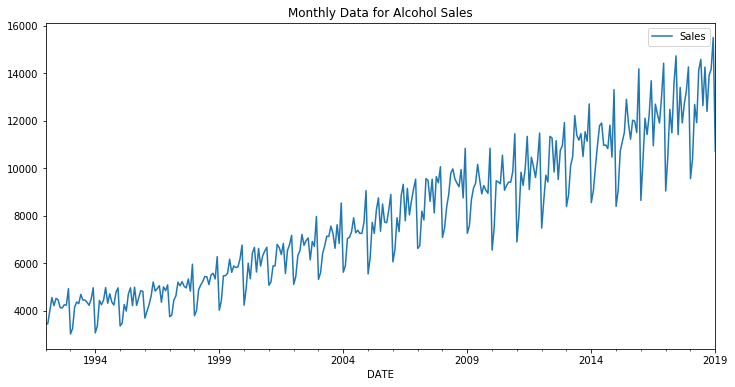

In [8]:
title = 'Monthly Data for Alcohol Sales'
df.plot(title=title);

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

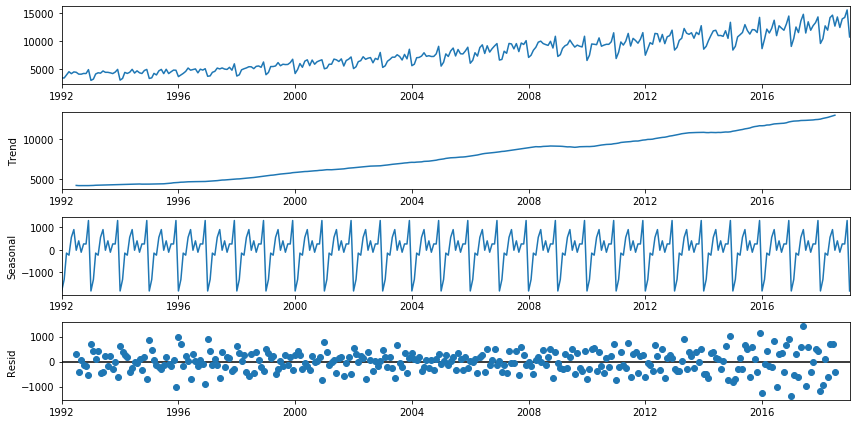

In [10]:
seasonal_decompose(df, model='add').plot();

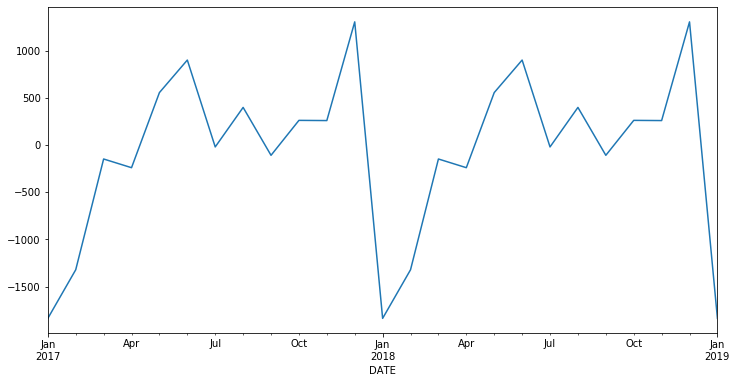

In [11]:
seasonal_decompose(df, model='add').seasonal.loc['2017':].plot();

# yearly data

In [12]:
len(df)

325

In [13]:
train = df.iloc[:313]
test = df.iloc[313:]

# Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()


In [16]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [18]:
scaled_train

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ],
       [0.0196598 ],
       [0.09650397],
       [0.11505257],
       [0.10906915],
       [0.14231986],
       [0.12197624],
       [0.12189076],
       [0.11394136],
       [0.10300026],
       [0.12556629],
       [0.16608257],
       [0.00376101],
       [0.02957518],
       [0.12069408],
       [0.10513719],
       [0.12214719],
       [0.16702282],
       [0.11052227],
       [0.14428584],
       [0.11479614],
       [0.10402599],
       [0.14984187],
       [0.16582614],
       [0.02897684],
       [0.03872126],
       [0.10582101],
       [0.08231473],
       [0.14394393],
       [0.16608257],
       [0.10188905],
       [0.16830498],
       [0.10291478],
       [0.13018207],
       [0.15556885],
       [0.153

# Time series Generator

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
n_inputs = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_inputs, batch_size=1)

In [21]:
X, y = generator[0]
X.shape


(1, 12, 1)

In [22]:
y, y.shape

(array([[0.]]), (1, 1))

# Create the model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               58560     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit_generator(generator, epochs=25)

Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
301/301 [==============================] - 5s 15ms/step - loss: 0.0227
Epoch 2/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0097
Epoch 3/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0082
Epoch 4/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0077
Epoch 5/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0066
Epoch 6/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0068
Epoch 7/25
301/301 [==============================] - 5s 17ms/step - loss: 0.0043
Epoch 8/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0041
Epoch 9/25
301/301 [==============================] - 5s 16ms/step - loss: 0.0033
Epoch 10/25
301/301 [==============================] - 6s 18ms/step - loss: 0.0033
Epoch 11/25
301/301 [==============================] - 6s 19ms/step - loss: 0.0024: 0

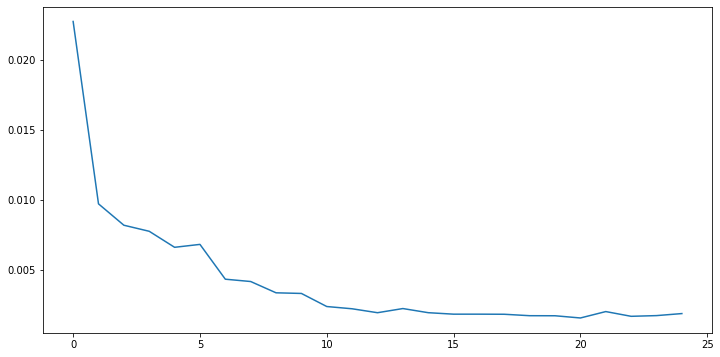

In [27]:
my_loss = model.history.history['loss']
plt.plot(range(len(my_loss)), my_loss)

# Predicting the first test value by using a batch of previous 12 points

In [28]:
model.predict(scaled_train[-12:].reshape(1,n_inputs, n_features))[0]

array([0.732255], dtype=float32)

In [29]:
scaled_test[0]

array([0.63116506])

# Predicting all the test values

In [42]:
test_predictions = []
eval_batch = scaled_train[-n_inputs:]
current_batch = eval_batch.reshape(1,n_inputs,n_features)

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [43]:
predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predicted'] = predictions

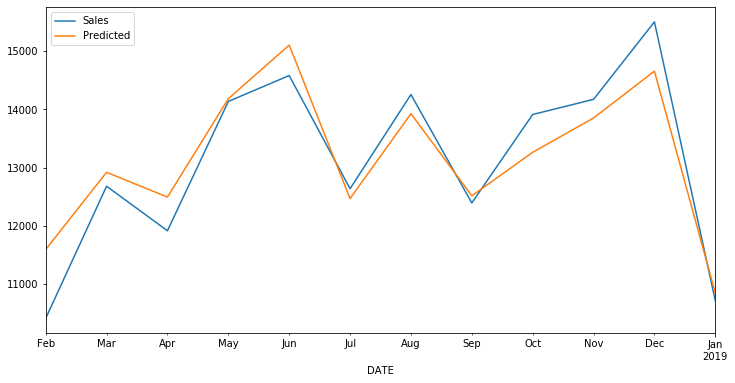

In [45]:
test.plot();

In [46]:
from sklearn.metrics import mean_squared_error

In [49]:
print('MSE: {}'.format(mean_squared_error(test['Sales'], test['Predicted'])))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test['Sales'], test['Predicted']))))

MSE: 289321.156035444
RMSE: 537.8858206305907


In [50]:
test['Sales'].mean()

13111.75